Pytorch example for VAE: [link](https://github.com/pytorch/examples/blob/main/vae/main.py)



In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

c:\Users\Vimarsh\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 9912422/9912422 [00:03<00:00, 2626503.63it/s]


Extracting ./mnist_data/MNIST\raw\train-images-idx3-ubyte.gz to ./mnist_data/MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 2306907.14it/s]


Extracting ./mnist_data/MNIST\raw\train-labels-idx1-ubyte.gz to ./mnist_data/MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 2134561.39it/s]


Extracting ./mnist_data/MNIST\raw\t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST\raw



In [105]:
def gaussian_like(mean, variance, std):
        # Create a Gaussian distribution with the given mean and variance
        distribution = torch.distributions.Normal(mean, variance.sqrt())
        
        # Sample from the distribution and scale by the standard deviation
        sample = distribution.sample()
        output = sample * std
        
        return output

In [109]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std) #
        return eps.mul(std).add_(mu) # return z sample
    
    
    
    def sampling2(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = gaussian_like(torch.tensor(1.0),torch.tensor(2.0), std) #
        return eps.mul(std).add_(mu) # return z sample
    
    # IGNORE BELOW
    # standard normal
    def sampling_standard_normal(self, mu, log_var):
        # std = torch.exp(0.5*log_var)
        # eps = torch.distributions.Normal(0,1)
        # return torch.distributions.Normal(mu, log_var).sample().mul(torch.exp(0.5*log_var)).add_(mu)
        return torch.distributions.Normal(mu, log_var).sample()

    # mean = 1, std = 2
    def gaussian_sampling(self, mu, log_var):
        return torch.distributions.Normal(1, 2).sample()
    
    # beta distribution
    def beta_sampling(self, alpha, beta):
        alpha = torch.ones_like(alpha) * 2  # set alpha to 2
        beta = torch.ones_like(beta) * 2  # set beta to 2
        return torch.distributions.beta.Beta(alpha, beta).sample()
    
    # gamma 3,2 distribution
    def gamma_sampling(self, alpha, beta):
        alpha = torch.ones_like(alpha) * 3  # set alpha to 3
        beta = torch.ones_like(beta) * 2  # set beta to 2
        return torch.distributions.gamma.Gamma(alpha, beta).sample()
                
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling2(mu, log_var)
        # z = self.sampling_standard_normal(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()

In [99]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [100]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [101]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        if(torch.cuda.is_available()):
            data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [102]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            if(torch.cuda.is_available()):
                data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [69]:
for epoch in range(1, 10):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 544.106484
Train Epoch: 1 [10000/60000 (17%)]	Loss: 544.151797
Train Epoch: 1 [20000/60000 (33%)]	Loss: 544.221953
Train Epoch: 1 [30000/60000 (50%)]	Loss: 544.170547
Train Epoch: 1 [40000/60000 (67%)]	Loss: 544.137734
Train Epoch: 1 [50000/60000 (83%)]	Loss: 544.048477
====> Epoch: 1 Average loss: 544.1036
====> Test set loss: 544.1630
Train Epoch: 2 [0/60000 (0%)]	Loss: 544.541953
Train Epoch: 2 [10000/60000 (17%)]	Loss: 544.251875
Train Epoch: 2 [20000/60000 (33%)]	Loss: 544.103945
Train Epoch: 2 [30000/60000 (50%)]	Loss: 544.083555
Train Epoch: 2 [40000/60000 (67%)]	Loss: 543.874766
Train Epoch: 2 [50000/60000 (83%)]	Loss: 544.113359
====> Epoch: 2 Average loss: 544.1015
====> Test set loss: 544.1673
Train Epoch: 3 [0/60000 (0%)]	Loss: 544.360312
Train Epoch: 3 [10000/60000 (17%)]	Loss: 544.038281
Train Epoch: 3 [20000/60000 (33%)]	Loss: 543.990977
Train Epoch: 3 [30000/60000 (50%)]	Loss: 543.887187
Train Epoch: 3 [40000/60000 (67%)]	Loss: 544.06

In [70]:
# with torch.no_grad():
#     z = torch.randn(64, 2).cuda()
#     sample = vae.decoder(z).cuda()
    
#     save_image(sample.view(64, 1, 28, 28), './samples/sample_' + '.png')

with torch.no_grad():
    z = torch.randn(64, 2) 
    # print(z)
    sample = vae.decoder(z)
    
    sample2 = vae.decoder(torch.Tensor([0, -0.5]))
    
    save_image(sample.view(64, 1, 28, 28), './sample_v1_' + '.png')
    save_image(sample2.view(1, 1, 28, 28), './sample_v1_2_' + '.png')




In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

latent_space = vae.encoder(data2)

# Use t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2)
latent_space_2d = tsne.fit_transform(latent_space)

# Plot the 2D latent space
plt.scatter(latent_space_2d[:, 0], latent_space_2d[:, 1])
plt.show()

In [103]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# Define the VAE model
class VAE2(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=256, latent_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        mean = self.fc2_mean(h)
        logvar = self.fc2_logvar(h)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mean, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

# Define training parameters
batch_size = 128
learning_rate = 1e-3
num_epochs = 100

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize the VAE model
# vae = VAE()
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

# Define loss function
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [110]:
# Training loop
vae.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader.dataset)}")

Epoch 1/100: 100%|██████████| 469/469 [00:12<00:00, 37.61it/s]


Epoch 1/100, Loss: 548.0140991536458


Epoch 2/100: 100%|██████████| 469/469 [00:12<00:00, 38.46it/s]


Epoch 2/100, Loss: 548.003066796875


Epoch 3/100: 100%|██████████| 469/469 [00:17<00:00, 26.17it/s]


Epoch 3/100, Loss: 548.0472122395834


Epoch 4/100: 100%|██████████| 469/469 [00:12<00:00, 38.87it/s]


Epoch 4/100, Loss: 548.1939986328125


Epoch 5/100: 100%|██████████| 469/469 [00:12<00:00, 38.23it/s]


Epoch 5/100, Loss: 547.799753515625


Epoch 6/100: 100%|██████████| 469/469 [00:12<00:00, 37.62it/s]


Epoch 6/100, Loss: 547.74937109375


Epoch 7/100: 100%|██████████| 469/469 [00:12<00:00, 38.01it/s]


Epoch 7/100, Loss: 547.9313177734375


Epoch 8/100: 100%|██████████| 469/469 [00:12<00:00, 37.98it/s]


Epoch 8/100, Loss: 548.3278064453125


Epoch 9/100: 100%|██████████| 469/469 [00:12<00:00, 37.80it/s]


Epoch 9/100, Loss: 548.4277589192708


Epoch 10/100: 100%|██████████| 469/469 [00:12<00:00, 36.27it/s]


Epoch 10/100, Loss: 547.9694790364583


Epoch 11/100: 100%|██████████| 469/469 [00:12<00:00, 37.46it/s]


Epoch 11/100, Loss: 548.0871938802084


Epoch 12/100: 100%|██████████| 469/469 [00:12<00:00, 36.93it/s]


Epoch 12/100, Loss: 547.9870158203125


Epoch 13/100: 100%|██████████| 469/469 [00:12<00:00, 37.14it/s]


Epoch 13/100, Loss: 547.9202500651041


Epoch 14/100: 100%|██████████| 469/469 [00:12<00:00, 37.17it/s]


Epoch 14/100, Loss: 547.9987038411458


Epoch 15/100: 100%|██████████| 469/469 [00:13<00:00, 34.28it/s]


Epoch 15/100, Loss: 548.034918359375


Epoch 16/100: 100%|██████████| 469/469 [00:12<00:00, 37.42it/s]


Epoch 16/100, Loss: 548.0752359375


Epoch 17/100: 100%|██████████| 469/469 [00:12<00:00, 37.60it/s]


Epoch 17/100, Loss: 548.0903680989584


Epoch 18/100: 100%|██████████| 469/469 [00:12<00:00, 37.68it/s]


Epoch 18/100, Loss: 548.084351171875


Epoch 19/100: 100%|██████████| 469/469 [00:12<00:00, 37.98it/s]


Epoch 19/100, Loss: 547.9205751953125


Epoch 20/100: 100%|██████████| 469/469 [00:12<00:00, 36.63it/s]


Epoch 20/100, Loss: 547.9527486979167


Epoch 21/100: 100%|██████████| 469/469 [00:12<00:00, 38.46it/s]


Epoch 21/100, Loss: 548.0168049479166


Epoch 22/100: 100%|██████████| 469/469 [00:12<00:00, 37.83it/s]


Epoch 22/100, Loss: 548.1685330078125


Epoch 23/100: 100%|██████████| 469/469 [00:12<00:00, 37.18it/s]


Epoch 23/100, Loss: 548.0408295572917


Epoch 24/100: 100%|██████████| 469/469 [00:12<00:00, 37.07it/s]


Epoch 24/100, Loss: 547.9643899739583


Epoch 25/100: 100%|██████████| 469/469 [00:14<00:00, 31.99it/s]


Epoch 25/100, Loss: 547.8772779947917


Epoch 26/100: 100%|██████████| 469/469 [00:13<00:00, 35.18it/s]


Epoch 26/100, Loss: 547.8741201171875


Epoch 27/100: 100%|██████████| 469/469 [00:12<00:00, 37.14it/s]


Epoch 27/100, Loss: 547.8355556640626


Epoch 28/100: 100%|██████████| 469/469 [00:12<00:00, 38.87it/s]


Epoch 28/100, Loss: 547.9527790364583


Epoch 29/100: 100%|██████████| 469/469 [00:12<00:00, 37.07it/s]


Epoch 29/100, Loss: 548.20431015625


Epoch 30/100: 100%|██████████| 469/469 [00:12<00:00, 37.38it/s]


Epoch 30/100, Loss: 548.0110950520833


Epoch 31/100: 100%|██████████| 469/469 [00:12<00:00, 38.49it/s]


Epoch 31/100, Loss: 548.2308431640625


Epoch 32/100: 100%|██████████| 469/469 [00:12<00:00, 38.04it/s]


Epoch 32/100, Loss: 547.80606171875


Epoch 33/100: 100%|██████████| 469/469 [00:12<00:00, 38.66it/s]


Epoch 33/100, Loss: 547.9360588541666


Epoch 34/100: 100%|██████████| 469/469 [00:12<00:00, 37.38it/s]


Epoch 34/100, Loss: 548.1973201171875


Epoch 35/100: 100%|██████████| 469/469 [00:12<00:00, 36.90it/s]


Epoch 35/100, Loss: 548.0821323567708


Epoch 36/100: 100%|██████████| 469/469 [00:12<00:00, 37.07it/s]


Epoch 36/100, Loss: 548.4456170572917


Epoch 37/100: 100%|██████████| 469/469 [00:12<00:00, 37.39it/s]


Epoch 37/100, Loss: 548.0559167317708


Epoch 38/100: 100%|██████████| 469/469 [00:12<00:00, 38.25it/s]


Epoch 38/100, Loss: 547.8010794921875


Epoch 39/100: 100%|██████████| 469/469 [00:13<00:00, 34.92it/s]


Epoch 39/100, Loss: 547.804235546875


Epoch 40/100: 100%|██████████| 469/469 [00:12<00:00, 36.40it/s]


Epoch 40/100, Loss: 547.9680479817708


Epoch 41/100: 100%|██████████| 469/469 [00:12<00:00, 36.95it/s]


Epoch 41/100, Loss: 548.0856578776041


Epoch 42/100: 100%|██████████| 469/469 [00:12<00:00, 36.59it/s]


Epoch 42/100, Loss: 547.6856184244791


Epoch 43/100: 100%|██████████| 469/469 [00:13<00:00, 35.63it/s]


Epoch 43/100, Loss: 548.0575613932292


Epoch 44/100: 100%|██████████| 469/469 [00:12<00:00, 36.90it/s]


Epoch 44/100, Loss: 548.0025358723958


Epoch 45/100: 100%|██████████| 469/469 [00:12<00:00, 36.48it/s]


Epoch 45/100, Loss: 548.089620703125


Epoch 46/100: 100%|██████████| 469/469 [00:12<00:00, 37.82it/s]


Epoch 46/100, Loss: 547.9398099609375


Epoch 47/100: 100%|██████████| 469/469 [00:12<00:00, 36.87it/s]


Epoch 47/100, Loss: 548.1125087890625


Epoch 48/100: 100%|██████████| 469/469 [00:12<00:00, 37.14it/s]


Epoch 48/100, Loss: 548.2617072916667


Epoch 49/100: 100%|██████████| 469/469 [00:13<00:00, 35.63it/s]


Epoch 49/100, Loss: 547.9518776041666


Epoch 50/100: 100%|██████████| 469/469 [00:12<00:00, 38.28it/s]


Epoch 50/100, Loss: 548.3040589192708


Epoch 51/100: 100%|██████████| 469/469 [00:12<00:00, 36.67it/s]


Epoch 51/100, Loss: 547.8544778645834


Epoch 52/100: 100%|██████████| 469/469 [00:12<00:00, 37.37it/s]


Epoch 52/100, Loss: 547.99441484375


Epoch 53/100: 100%|██████████| 469/469 [00:12<00:00, 37.28it/s]


Epoch 53/100, Loss: 548.29517890625


Epoch 54/100: 100%|██████████| 469/469 [00:12<00:00, 36.68it/s]


Epoch 54/100, Loss: 548.0346880208333


Epoch 55/100: 100%|██████████| 469/469 [00:12<00:00, 37.17it/s]


Epoch 55/100, Loss: 548.3034447265625


Epoch 56/100: 100%|██████████| 469/469 [00:12<00:00, 37.68it/s]


Epoch 56/100, Loss: 548.3612766927083


Epoch 57/100: 100%|██████████| 469/469 [00:12<00:00, 36.96it/s]


Epoch 57/100, Loss: 547.9828158854167


Epoch 58/100: 100%|██████████| 469/469 [00:12<00:00, 37.25it/s]


Epoch 58/100, Loss: 548.1616174479167


Epoch 59/100: 100%|██████████| 469/469 [00:12<00:00, 37.28it/s]


Epoch 59/100, Loss: 548.0540259114583


Epoch 60/100: 100%|██████████| 469/469 [00:12<00:00, 36.71it/s]


Epoch 60/100, Loss: 548.0143055989583


Epoch 61/100: 100%|██████████| 469/469 [00:12<00:00, 37.95it/s]


Epoch 61/100, Loss: 548.2465548177083


Epoch 62/100: 100%|██████████| 469/469 [00:12<00:00, 37.77it/s]


Epoch 62/100, Loss: 548.1684174479167


Epoch 63/100: 100%|██████████| 469/469 [00:12<00:00, 37.13it/s]


Epoch 63/100, Loss: 548.0349843098959


Epoch 64/100: 100%|██████████| 469/469 [00:12<00:00, 37.68it/s]


Epoch 64/100, Loss: 548.3457654296875


Epoch 65/100: 100%|██████████| 469/469 [00:12<00:00, 37.60it/s]


Epoch 65/100, Loss: 547.9806393880208


Epoch 66/100: 100%|██████████| 469/469 [00:12<00:00, 37.93it/s]


Epoch 66/100, Loss: 548.2484285807292


Epoch 67/100: 100%|██████████| 469/469 [00:12<00:00, 36.90it/s]


Epoch 67/100, Loss: 548.0819108072917


Epoch 68/100: 100%|██████████| 469/469 [00:12<00:00, 38.22it/s]


Epoch 68/100, Loss: 547.8427274739583


Epoch 69/100: 100%|██████████| 469/469 [00:12<00:00, 37.88it/s]


Epoch 69/100, Loss: 548.019569140625


Epoch 70/100: 100%|██████████| 469/469 [00:12<00:00, 37.98it/s]


Epoch 70/100, Loss: 547.9719410807292


Epoch 71/100: 100%|██████████| 469/469 [00:12<00:00, 38.48it/s]


Epoch 71/100, Loss: 547.637430859375


Epoch 72/100: 100%|██████████| 469/469 [00:13<00:00, 35.50it/s]


Epoch 72/100, Loss: 547.9396145833333


Epoch 73/100: 100%|██████████| 469/469 [00:12<00:00, 36.80it/s]


Epoch 73/100, Loss: 548.0685483072916


Epoch 74/100: 100%|██████████| 469/469 [00:12<00:00, 38.45it/s]


Epoch 74/100, Loss: 547.8884367838542


Epoch 75/100: 100%|██████████| 469/469 [00:12<00:00, 36.66it/s]


Epoch 75/100, Loss: 547.6628973307292


Epoch 76/100: 100%|██████████| 469/469 [00:12<00:00, 38.49it/s]


Epoch 76/100, Loss: 548.0491138671875


Epoch 77/100: 100%|██████████| 469/469 [00:12<00:00, 37.00it/s]


Epoch 77/100, Loss: 547.9984893229166


Epoch 78/100: 100%|██████████| 469/469 [00:12<00:00, 37.69it/s]


Epoch 78/100, Loss: 548.1280940104167


Epoch 79/100: 100%|██████████| 469/469 [00:12<00:00, 38.57it/s]


Epoch 79/100, Loss: 547.9487576822917


Epoch 80/100: 100%|██████████| 469/469 [00:12<00:00, 37.97it/s]


Epoch 80/100, Loss: 547.6981752604166


Epoch 81/100: 100%|██████████| 469/469 [00:12<00:00, 38.17it/s]


Epoch 81/100, Loss: 548.2486680989583


Epoch 82/100: 100%|██████████| 469/469 [00:12<00:00, 36.80it/s]


Epoch 82/100, Loss: 547.9638984375


Epoch 83/100: 100%|██████████| 469/469 [00:12<00:00, 37.76it/s]


Epoch 83/100, Loss: 548.5584475911459


Epoch 84/100: 100%|██████████| 469/469 [00:12<00:00, 38.05it/s]


Epoch 84/100, Loss: 547.9325180989583


Epoch 85/100: 100%|██████████| 469/469 [00:12<00:00, 36.85it/s]


Epoch 85/100, Loss: 548.0860646484375


Epoch 86/100: 100%|██████████| 469/469 [00:12<00:00, 38.02it/s]


Epoch 86/100, Loss: 547.90603125


Epoch 87/100: 100%|██████████| 469/469 [00:14<00:00, 32.68it/s]


Epoch 87/100, Loss: 548.2569057291666


Epoch 88/100: 100%|██████████| 469/469 [00:12<00:00, 37.83it/s]


Epoch 88/100, Loss: 548.16659765625


Epoch 89/100: 100%|██████████| 469/469 [00:12<00:00, 37.60it/s]


Epoch 89/100, Loss: 548.2228259114584


Epoch 90/100: 100%|██████████| 469/469 [00:12<00:00, 37.60it/s]


Epoch 90/100, Loss: 548.2512285807292


Epoch 91/100: 100%|██████████| 469/469 [00:12<00:00, 36.86it/s]


Epoch 91/100, Loss: 548.0923641927084


Epoch 92/100: 100%|██████████| 469/469 [00:12<00:00, 36.93it/s]


Epoch 92/100, Loss: 548.1195718098959


Epoch 93/100: 100%|██████████| 469/469 [00:12<00:00, 37.61it/s]


Epoch 93/100, Loss: 547.6483145833333


Epoch 94/100: 100%|██████████| 469/469 [00:12<00:00, 38.21it/s]


Epoch 94/100, Loss: 547.7172130859375


Epoch 95/100: 100%|██████████| 469/469 [00:12<00:00, 37.21it/s]


Epoch 95/100, Loss: 548.0014014322917


Epoch 96/100: 100%|██████████| 469/469 [00:13<00:00, 35.29it/s]


Epoch 96/100, Loss: 547.6056409505209


Epoch 97/100: 100%|██████████| 469/469 [00:12<00:00, 36.11it/s]


Epoch 97/100, Loss: 547.9623610026042


Epoch 98/100: 100%|██████████| 469/469 [00:13<00:00, 35.71it/s]


Epoch 98/100, Loss: 547.9330662760417


Epoch 99/100: 100%|██████████| 469/469 [00:12<00:00, 37.67it/s]


Epoch 99/100, Loss: 548.0814177083333


Epoch 100/100: 100%|██████████| 469/469 [00:12<00:00, 38.06it/s]

Epoch 100/100, Loss: 547.9156540364584


In [111]:

# Generate samples from standard normal distribution
vae.eval()
with torch.no_grad():
    z = torch.randn(64, 2)
    sample = vae.decoder(z).view(-1, 1, 28, 28)
    torchvision.utils.save_image(sample, 'standard_normal_samples.png', nrow=8)

# Generate samples from Gaussian distribution with mean 1 and std 2
vae.eval()
with torch.no_grad():
    z = torch.randn(64, 2) * 2 + 1  # scaling the standard normal samples
    sample = vae.decoder(z).view(-1, 1, 28, 28)
    torchvision.utils.save_image(sample, 'gaussian_samples.png', nrow=8)


In [112]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [113]:
import torch.distributions as D

# Modify the generation of samples from the beta distribution
def generate_beta_samples(num_samples, latent_dim=2):
    # Calculate parameters of the beta distribution
    alpha = 1
    beta = (2 - 1) / 2  # Desired mean = 1, Desired std = 2
    # Sample from the beta distribution
    beta_dist = D.Beta(alpha, beta)
    samples = beta_dist.sample((num_samples, latent_dim))
    return samples

# Generate samples from the beta distribution
vae.eval()
with torch.no_grad():
    z = generate_beta_samples(64)
    sample = vae.decoder(z).view(-1, 1, 28, 28)
    torchvision.utils.save_image(sample, 'beta_samples.png', nrow=8)


In [114]:
# Modify the generation of samples from the Gamma distribution
def generate_gamma_samples(num_samples, latent_dim=2):
    # Parameters of the Gamma distribution
    concentration = torch.tensor([3.0])
    rate = torch.tensor([2.0])
    # Sample from the Gamma distribution
    gamma_dist = D.Gamma(concentration, rate)
    samples = gamma_dist.sample((num_samples, latent_dim)).squeeze()  # Remove extra dimension
    return samples

# Generate samples from the Gamma distribution
vae.eval()
with torch.no_grad():
    z = generate_gamma_samples(64, latent_dim=2)
    z = z.unsqueeze(2).expand(-1, -1, 256)  # Expand to match hidden dimension of the model
    z = z.view(-1, 256)  # Reshape to match input dimension of the model
    sample = vae.decoder(z).view(-1, 1, 28, 28)
    torchvision.utils.save_image(sample, 'gamma_samples.png', nrow=8)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x256 and 2x256)

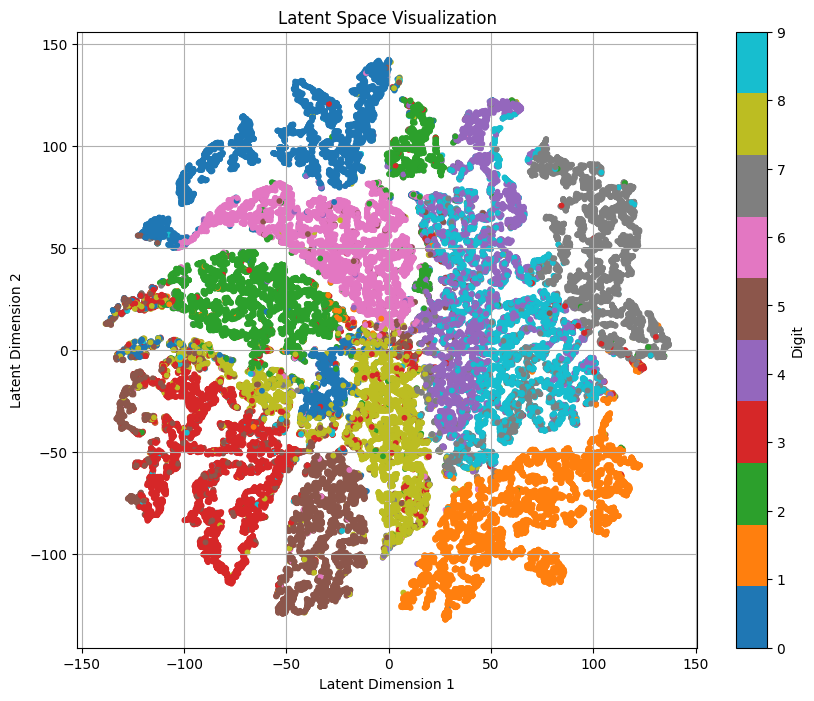

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Function to encode input data into the latent space
def encode_data(vae, data_loader):
    vae.eval()
    latent_vectors = []
    labels = []
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(data_loader):
            _, mu, _ = vae(data)
            latent_vectors.append(mu)
            labels.append(label)
    latent_vectors = torch.cat(latent_vectors, dim=0)
    labels = torch.cat(labels, dim=0)
    return latent_vectors, labels

# Encode data into the latent space
train_latent_vectors, train_labels = encode_data(vae, train_loader)

# Perform dimensionality reduction for visualization
tsne = TSNE(n_components=2, random_state=42)
latent_tsne = tsne.fit_transform(train_latent_vectors)

# Plot the latent space
plt.figure(figsize=(10, 8))
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=train_labels, cmap='tab10', s=10)
plt.colorbar(label='Digit')
plt.title('Latent Space Visualization')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True)
plt.show()
